# Final Report_v1

* Project Name : TW stock prediction with crawl and visualize
* Author : 楊右宇  
* Establish Date：2021.05.22  
* Last Modified Date：2021.06.12

download the graphviz first to show the decision tree visualize


https://www.graphviz.org/download/

In [1]:
!pip install scikit-learn

In [2]:
!pip install graphviz

In [3]:
!pip install mplfinance

# import library

In [4]:
import pandas as pd
import numpy as np
import math
import mplfinance as mpf
# import yfinance as y
# 匯入決策樹分類器
from sklearn.tree import DecisionTreeClassifier
# 要計算混淆矩陣的話，要從 metrics 裡匯入 confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
import graphviz 
# 要計算 AUC 的話，要從 metrics 裡匯入 roc_curve 以及 auc
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import shutil
import os
from cgitb import html
import pandas as pd 
import re
import time
from time import sleep
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
# 控制選單
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC

# 資料爬取

In [5]:
def crawl_stock_tw_v1(_ticker, _year):
    url = r'https://www.twse.com.tw/zh/page/trading/exchange/STOCK_DAY.html' 
    s = Service(r'C:\SDK\chromedriver_win32\chromedriver.exe')

    browser = webdriver.Chrome(service=s) 
    browser.maximize_window() 
    browser.get(url) 
    sleep(1)

    browser.find_element(by=By.XPATH, value='//*[@id="main-form"]/div/div/form/input').send_keys(str(_ticker))

    Select(browser.find_element(by=By.NAME, value='yy')).select_by_value(_year)

    browser.find_element(by=By.XPATH, value='//*[@id="main-form"]/div/div/form/a[2]').click()

    for i in range(12):
        # 選取表單_設定月分
        Select(browser.find_element(by=By.NAME, value='mm')).select_by_index(i)
        # 點擊查詢按鈕
        browser.find_element(by=By.XPATH, value='//*[@id="main-form"]/div/div/form/a[2]').click()
        # 點擊下載按鈕
        csv = WebDriverWait(browser, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "csv")))
        time.sleep(5)
        csv.click()

    time.sleep(1)
    browser.close()

In [ ]:
https://www.tpex.org.tw/web/stock/aftertrading/daily_trading_info/st43.php?l=zh-tw&d=111/11&stkno=3169&s=0,asc,0

In [6]:
def crawl_stock_tw_v2(_ticker, _year):

    s = Service(r'C:\SDK\chromedriver_win32\chromedriver.exe')
    browser = webdriver.Chrome(service=s) 
    browser.maximize_window() 

    for i in range(1, 13):
        url = 'https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=csv&date={}{:02}01&stockNo={}'.format(_year, i, _ticker)
        browser.get(url) 
        sleep(5)

    browser.close()

In [13]:
def crawl_stock_tw_v3(_ticker, _year):

    s = Service(r'C:\SDK\chromedriver_win32\chromedriver.exe')
    browser = webdriver.Chrome(service=s) 
    browser.maximize_window() 

    for i in range(1, 13):
        # url = 'https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=csv&date={}{:02}01&stockNo={}'.format(_year, i, _ticker)
        url = f'https://www.tpex.org.tw/web/stock/aftertrading/daily_trading_info/st43_download_UTF-8.php?l=zh-tw&d={_year-1911}/{i:02}&stkno={_ticker}&s=0,asc,0'
        browser.get(url) 
        sleep(5)

    browser.close()

In [7]:
def move_stock_tw(_ticker):
    # 判定 os_test 資料夾是否存在
    if not os.path.isdir('data_unmerged'): 
        os.mkdir('data_unmerged')
    # 取得當前路徑
    destination = os.getcwd() + '\\data_unmerged' 

    source = os.listdir(r"C:\Users\User\Downloads")
    #過濾其他檔案，只保留csv檔
    source = [line for line in source if str(_ticker) in line] 
    print(source)

    # 移動下載檔案進入資料夾
    for s in source:
        path = os.path.join(r"C:\Users\User\Downloads", s)
        shutil.move(path, os.path.join(destination, s))

In [8]:
def merge_stock_tw(_ticker):
    
    # 判定 data 資料夾是否存在
    if not os.path.isdir('data'): 
        os.mkdir('data')
    
    path = os.getcwd() + '\\data_unmerged\\'
    source = os.listdir(path)
    source = [line for line in source if str(_ticker) in line]
    
    if os.path.isfile(r'./data/{}.csv'.format(str(_ticker))): 
        res = pd.read_csv(os.getcwd() + '\\data\{}.csv'.format(str(_ticker)))
    else:
        res = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    
    for s in source:
        print(s)
        df = pd.read_csv(path + s, encoding='Big5', skiprows=1)
        df = df.iloc[:-4, :7]
        df.columns = ['Date', 'Volume', 'b', 'Open', 'High', 'Low', 'Close']
        df.drop('b', axis = 1, inplace = True) 
        df = df.reindex(columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
        df.loc[:, 'Date'] = df.loc[:, 'Date'].str.split('/').apply(lambda x:(str(int(x[0]) + 1911)) + '/' + x[1].removeprefix('0') + '/' + x[2].removeprefix('0'))
        df.loc[:, 'Volume'] = df.loc[:, 'Volume'].str.replace(',', '').astype(int) // 1000
        res = res.append(df, ignore_index = True)
    
    
    res['Date'] = pd.to_datetime(res['Date'])
    res = res.drop_duplicates(subset='Date', keep='first')
    res.sort_values(by='Date', ascending=True, inplace=True)
    
    res.to_csv(os.getcwd() + '\\data\\' + str(_ticker) + '.csv', index = False, encoding='utf-8')

# Indicators

## Moving Average
* 均線

In [7]:
def MA(_ticker, period=10, field='Close'):

    '''可以自訂要幾日均線，也可以計算成交量等數值的均線'''
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)
    
    if field == 'Volume':
        res['VMA_' + str(period)] = _ticker[field].rolling(period).mean()

    else:
        res['MA_' + str(period)] = _ticker[field].rolling(period).mean()

    return res

## EMA

In [10]:
def EMA(_ticker, period=15):
    
    '''計算EMA，並新增在 DataFrame 中，數值為指數衰減'''

    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)
    
    # 新增新的一欄在 DataFrame 中
    res['EMA_' + str(period)] = _ticker['Close'].ewm(span=period, adjust=False).mean()

    return res

## RSI

* Relative Strength Index
* 相對強弱指標
* 計算出一個 0 ~ 100 之間的數字
* 越接近 0 表示盤勢越弱
* 越接近 100 表示盤勢越強

In [11]:
def RSI(_ticker, period = 14):
    
    # 創建暫存資料
    tmp = pd.DataFrame(index=_ticker.index)

    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)
    
    # 新增新資料欄位，預設為空
    tmp['rise'] = np.nan

    # 搜尋特定欄位之 index
    col_rise = tmp.columns.get_loc('rise')
    col_close = _ticker.columns.get_loc('Close')

    # 計算今日漲跌數字
    for i in range(1, len(_ticker)):
        tmp.iloc[i, col_rise] = (_ticker.iloc[i, col_close] - _ticker.iloc[i - 1, col_close])

    # 創建空資料欄
    tmp['rise_only'] = tmp['rise']
    tmp['drop_only'] = tmp['rise']

    # 依照數值大小於零分堆
    tmp['rise_only'].loc[tmp['rise'] < 0] = 0
    tmp['drop_only'].loc[tmp['rise'] > 0] = 0
    
    # 計算 N 天內平均漲跌數值
    tmp['rise_avg'] = tmp['rise_only'].rolling(period).mean()
    tmp['drop_avg'] = tmp['drop_only'].rolling(period).mean().abs()

    # 計算 RSI
    res['RSI'] = tmp['rise_avg'] / (tmp['rise_avg'] + tmp['drop_avg']) * 100
    
    return res

## KD

* Ｋ值比Ｄ值敏感，波動幅度較大
* Ｋ值線如果在低檔區由下而上穿過Ｄ值線，稱作黃金交叉，代表接下來盤勢上漲機會大
* Ｋ值線如果在高檔區由上而下穿過Ｄ值線，稱作死亡交叉，代表接下來盤勢下跌機會大

In [12]:
def KD(_ticker, period = 9):

    # 創建暫存資料
    tmp = pd.DataFrame(index=_ticker.index)

    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 尋找 N 日內最高最低價
    tmp['max_close'] = ticker['Close'].rolling(period, min_periods=1).max()
    tmp['min_close'] = ticker['Close'].rolling(period, min_periods=1).min()

    # 計算 RSI
    tmp['RSV'] = (ticker['Close'] - tmp['min_close']) / (tmp['max_close'] - tmp['min_close']) * 100

    # 由於 K D 之定義為遞迴式，且數值為 0 ~ 100，預設為 50
    res['K'] = 50
    res['D'] = 50
    
    # 搜尋特定欄位之 index
    col_k = res.columns.get_loc('K')
    col_d = res.columns.get_loc('D')
    col_rsv = tmp.columns.get_loc('RSV')

    # 計算 K 與 D 值
    for i in range(1, len(_ticker)):
        res.iloc[i, col_k] = res.iloc[i - 1, col_k] * 2 / 3 + tmp.iloc[i, col_rsv] * 1 / 3
        res.iloc[i, col_d] = res.iloc[i - 1, col_d] * 2 / 3 + res.iloc[i, col_k] * 1 / 3
    
    return res

## MACD

* macd（對應diff）
* macdsignal（對應dea）
* macdhist（對應macd）

### 簡易策略
* DIFF、DEA均為正，DIFF向上突破DEA，買入信號。

* DIFF、DEA均為負，DIFF向下跌破DEA，賣出信號。

* DEA線與K線發生背離，行情反轉信號。

* 分析MACD柱狀線，由正變負，賣出信號；由負變正，買入信號。

In [13]:
def MACD(_ticker, fast_period=12, slow_period=26, signal_period=9):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 計算快慢 EMA
    ema_f = _ticker['Close'].ewm(span=fast_period, adjust=False).mean()
    ema_s = _ticker['Close'].ewm(span=slow_period, adjust=False).mean()
    
    # 計算 MACD 值
    res['macd_dif'] = ema_f - ema_s
    res['macd_dea'] = res['macd_dif'].ewm(span=signal_period, adjust=False).mean()
    res['macd'] = res['macd_dif'] - res['macd_dea']

    return res

## Bollinger Bands

In [14]:
def BBands(_ticker, period=20, std_num=2):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 計算中線，也就是二十日 MA
    res['bbands_middle'] = _ticker['Close'].rolling(period).mean()
    
    # 計算標準差
    std = _ticker['Close'].rolling(period).std(ddof=0) 
    
    # 計算上下軌
    res['bbands_upper'] = res['bbands_middle'] + std * std_num 
    res['bbands_lower'] = res['bbands_middle'] - std * std_num

    return res

# 繪圖

## MUTI_PLOT

In [15]:
def plot_muti(_ticker, _title='', volume=True, buy_sell_point=False, 
    RSI=False, rsi_midline=False, rsi_bound=False, rsi_upper_bound=85, rsi_lower_bound=15, 
    KD=False, kd_bound=False, kd_upper_bound=85, kd_lower_bound=15, 
    MACD=False, BBands=False):

    apds = []
    _panel = 1

    # 繪製買賣點，並判斷繪圖範圍內是否存在買賣點，避免出錯
    if buy_sell_point:
        
        buy, sell = [np.nan], [np.nan]
        buy_b = False
        sell_b = False

        # 設定買賣點位，且避免遮擋到 K 線
        for i in range(1, len(_ticker)):

            if _ticker.loc[_ticker.index[i], 'ticker_num'] > _ticker.loc[_ticker.index[i - 1], 'ticker_num']:
                buy.append(_ticker.loc[_ticker.index[i], 'Low'] * 0.97)
                buy_b = True
            else:
                buy.append(np.nan)

            if _ticker.loc[_ticker.index[i], 'ticker_num'] < _ticker.loc[_ticker.index[i - 1], 'ticker_num']:
                sell.append(_ticker.loc[_ticker.index[i], 'High'] * 1.03)
                sell_b = True
            else:
                sell.append(np.nan)

        # 加入數據至圖中
        if buy_b:
            apds += [ 
            mpf.make_addplot(buy, panel=0, type = 'scatter', color = 'blue', marker = '^', markersize = 100)
            ]

        if sell_b:
            apds += [ 
                mpf.make_addplot(sell, panel=0, type = 'scatter', color = 'darkorange', marker = 'v', markersize = 100),
            ]

    # 加入 RSI 指標
    if RSI:

        _panel += 1
        apds += [ 
            mpf.make_addplot(_ticker['RSI'], panel = _panel - 1, color='#009393', ylabel='RSI', secondary_y=False)
        ]

        # 加入上下界線
        if rsi_bound:
            apds += [
                mpf.make_addplot(np.full((len(_ticker)), rsi_lower_bound), 
                    panel = _panel - 1, color='#F00078', alpha=0.5, secondary_y=False),
                mpf.make_addplot(np.full((len(_ticker)), rsi_upper_bound), 
                    panel = _panel - 1, color='#F00078', alpha=0.5, secondary_y=False)
            ]

        # 加入中線
        if rsi_midline:
            apds += [mpf.make_addplot(np.full((len(_ticker)), 50), 
                    panel = _panel - 1, color='#F00078', alpha=0.5)]

    # 加入 KD 指標
    if KD:

        _panel += 1
        apds += [ 
            mpf.make_addplot(_ticker['K'], panel=_panel - 1, color='#0000C6', 
                ylabel='KD'),
            mpf.make_addplot(_ticker['D'], panel=_panel - 1, color='#F75000'),
            ]

        # 加入上下界線
        if kd_bound:
            apds += [
                mpf.make_addplot(np.full((len(_ticker)), kd_upper_bound), 
                    panel=_panel - 1, color='#F00078', alpha=0.5, secondary_y=False),
                mpf.make_addplot(np.full((len(_ticker)), kd_lower_bound), 
                    panel=_panel - 1, color='#F00078', alpha=0.5, secondary_y=False)
            ]

    # 加入 MACD
    if MACD:

        _panel += 1
        apds += [
            mpf.make_addplot(_ticker['macd'], type='bar', ylabel='MACD', width=0.7, panel=_panel - 1,
                color='dimgray', alpha=1, secondary_y=False),
            mpf.make_addplot(_ticker['macd_dif'], panel=_panel - 1, color='fuchsia', secondary_y=True),
            mpf.make_addplot(_ticker['macd_dea'], panel=_panel - 1, color='b', secondary_y=True)
        ]

    # 如果要加成交量，層數加一
    if volume:
        _panel += 1

    # 加入布林帶
    if BBands:
        apds += [
            mpf.make_addplot(_ticker['bbands_middle'], panel=0, color='#9F4D95', alpha=1, width=1, secondary_y=False),
            mpf.make_addplot(_ticker['bbands_upper'], panel=0, color='black', alpha=0.5, width=0.8, secondary_y=False),
            mpf.make_addplot(_ticker['bbands_lower'], panel=0, color='black', alpha=0.5, width=0.8, secondary_y=False),
           
        ]

    # 設置k線圖顏色
    my_color = mpf.make_marketcolors(up='red',      # 上漲顏色
                                     down='green',  # 下跌顏色
                                     edge='i',      # 隱藏 K 線邊緣
                                     volume='in',   # 成交量用同樣的顏色
                                     inherit=True)  # 繼承其他參數

    # 設置圖型呈現
    my_style = mpf.make_mpf_style(gridaxis='both',          # 設置網格
                                  gridstyle='-.',           # 設定網格花樣
                                  y_on_right=True,          # y 座標放右邊
                                  marketcolors=my_color)    # 設定k線圖顏色

    mpf.plot(_ticker, 
        type='candle',              # 設定要繪製的類別
        num_panels=_panel,          # 設定總層數
        main_panel=0,               # 設定 K 線圖層數
        volume=volume,              # 設定是否繪製成交量 
        volume_panel=_panel - 1,    # 設定成交量層數
        addplot = apds,             # 加入其他數據
        figscale=1.5,               # 設定圖型大小
        style=my_style,             # 設定圖型呈現
        title=_title,               # 設定 title
        show_nontrading=False,      # 忽略非交易日
        tight_layout=False          # 設定布局方式
        )
    return

# 資料讀取

In [16]:
def read_ticker_v2(_ticker_code):
    
    try:
        import os
        
        # get the current working path of this file
        path = os.getcwd()

        # get the data as a dataframe 
        res = pd.read_csv(path + '\\data\{}'.format(str(_ticker_code)))

        # change the name of columns
        res.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

        # set the column "Date" to index
        res = res.set_index('Date')

        # set index column("Date") from string to datetime.datetime
        res.index = pd.to_datetime(res.index)

        # sort index column("Date") chronologically
        res = res.sort_index()

    except Exception as e:
        print(e)
        return False

    return res

In [61]:
def get_ticker_list():
    
    import os

    # get the current working path of this file
    path = os.getcwd()

    # get all files in this path
    list = os.listdir(path + '\\data')
    
    # filter out the stock file (.csv)
    res = [file for file in list if '.csv' in file]

    return res

# 資料回測

## V5

* 只會在停損停利點賣股票

In [18]:
def back_track_v5(_ticker, funds=1_000_000, stop_loss_percent=0.96):

    # 新增止損價
    stop_loss = 0 

    # 取得 index 值，方便計算使用
    t = _ticker.index

    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 新增資料欄位，方便下面運算
    res['ticker_num'] = 0
    res['income'] = 0
    res['expenditure'] = 0
    res['account'] = funds


    for i in range(1, len(_ticker)):
        
        # 做多點
        if i != len(_ticker) - 1 and _ticker.loc[t[i], 'buy_point'] == 1 \
                and res.loc[t[i - 1], 'ticker_num'] == 0 :
            
            # 計算可買最大張數
            res.loc[t[i], 'ticker_num'] \
                = math.floor(res.loc[t[i - 1], 'account'] / (_ticker.loc[t[i], 'Close'] * 1.001425))
            # 計算總花費
            res.loc[t[i], 'expenditure'] \
                = -res.loc[t[i], 'ticker_num'] * (_ticker.loc[t[i], 'Close'] * 1.001425)
            # 計算帳戶餘額
            res.loc[t[i], 'account'] = res.loc[t[i - 1], 'account'] + res.loc[t[i], 'expenditure']
            # 計算目前止損停利價格
            stop_loss = _ticker.loc[t[i], 'Close'] * stop_loss_percent
        
        # 移動停損停利點賣出 # 最後一天無條件賣出
        elif res.loc[t[i - 1], 'ticker_num'] > 0 and _ticker.loc[t[i], 'Close'] < stop_loss\
                or i == len(_ticker) - 1 and res.loc[_ticker.index[i - 1], 'ticker_num'] > 0:
            
            # 計算總收入
            res.loc[t[i], 'income'] \
                = res.loc[t[i - 1], 'ticker_num'] * (_ticker.loc[t[i], 'Close'] * 0.995575)
            # 更新現有張數
            res.loc[t[i], 'ticker_num'] = 0
            # 計算帳戶餘額
            res.loc[t[i], 'account'] = res.loc[t[i - 1], 'account'] + res.loc[t[i], 'income']
        
        else :
            # 更新此日持有股數
            res.loc[t[i], 'ticker_num'] = res.loc[t[i - 1], 'ticker_num']
            # 更新此日帳戶餘額
            res.loc[t[i], 'account'] = res.loc[t[i - 1], 'account']
            # 更新停損停利價格
            if _ticker.loc[t[i], 'Close'] * stop_loss_percent > stop_loss:
                stop_loss = _ticker.loc[t[i], 'Close'] * stop_loss_percent

    return res

# 資料數據整理

## 交易點數據

In [19]:
def get_trade_info_v2(_ticker):

    #紀錄總交易資訊
    detail = []
    #紀錄單列交易資訊
    temp_detail = []
    
    #買入價格，方便賣出時計算報酬
    buy_price = 0
    # 紀錄起始資金，方便計算總報酬
    funds = _ticker.loc[_ticker.index[0], 'account']

    for i in range(1, len(_ticker)):

        # buy info # 交易資訊
        if _ticker.loc[_ticker.index[i], 'ticker_num'] \
            > _ticker.loc[_ticker.index[i - 1], 'ticker_num']:
                    
            # 交易日期
            temp_detail.append(_ticker.index[i])
            # 交易數量(股)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'ticker_num'] \
                - _ticker.loc[_ticker.index[i - 1], 'ticker_num'])
            # 交易價格
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'])
            # 交易價格(含稅)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'] * 1.001425)
            # 總手續費(手續費加交易稅)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'] \
                * 0.001425 * _ticker.loc[_ticker.index[i], 'ticker_num'])
            # 總花費
            temp_detail.append(_ticker.loc[_ticker.index[i], 'expenditure'])
            # 此次交易報酬，買入時無資料
            temp_detail.append(np.nan)
            # 此次交易報酬率，買入時無資料
            temp_detail.append(np.nan)
            # 目前總交易報酬，買入時無資料
            temp_detail.append(np.nan)
            # 目前總交易報酬率，買入時無資料
            temp_detail.append(np.nan)
            # 目前帳戶餘額
            temp_detail.append(_ticker.loc[_ticker.index[i], 'account'])
            # 更新買價，方便下次賣出時計算
            buy_price = _ticker.loc[_ticker.index[i], 'expenditure']

            # 將資料推入串列
            detail.append(temp_detail)
            # 進入下一列
            temp_detail = []

        # sell info
        elif _ticker.loc[_ticker.index[i], 'ticker_num'] \
            < _ticker.loc[_ticker.index[i - 1], 'ticker_num']:
            
            # 交易日期
            temp_detail.append(_ticker.index[i])
            # 交易數量(股)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'ticker_num'] \
                - _ticker.loc[_ticker.index[i - 1], 'ticker_num'])
            # 交易價格
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'])
            # 交易價格(含稅)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'] * 0.995575)
            # 總手續費(手續費加交易稅)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'] \
                * 0.004425 *  _ticker.loc[_ticker.index[i - 1], 'ticker_num'])
            # 總收入 
            temp_detail.append(_ticker.loc[_ticker.index[i], 'income'])
            # 此次交易報酬
            temp_detail.append(_ticker.loc[_ticker.index[i], 'income'] + buy_price)
            # 此次交易報酬率
            temp_detail.append((_ticker.loc[_ticker.index[i], 'income'] + buy_price) / (-buy_price) * 100)
            # 目前總交易報酬
            temp_detail.append(_ticker.loc[_ticker.index[i], 'account'] - funds)
            # 目前總交易報酬率
            temp_detail.append((_ticker.loc[_ticker.index[i], 'account'] - funds) / funds * 100)
            # 目前帳戶餘額
            temp_detail.append(_ticker.loc[_ticker.index[i], 'account'])

            # 將資料推入串列
            detail.append(temp_detail)
            # 進入下一列
            temp_detail = []
            
    # 將串列改成 dataframe 後回傳，並加上各行名稱
    return pd.DataFrame(detail, columns=['Date', 'ticker_num', 'price', 'price(with_tax)', 'tax', 
        'spend', 'profit', 'profit_rate', 'profit_sum', 'profit_sum_rate', 'account'])

## 交易結論數據

In [20]:
def get_result(_df):
    # 回傳 買賣次數  贏 輸 勝率 報酬率
    # ['Trades', 'Win', 'Loss', 'Win_Rate', 'Profit']
    
    # 計算勝利的次數
    win = 0
    #計算敗的次數
    loss = 0
    
    # 報酬大於零是為勝利，反之為敗
    for i in range(1, len(_df), 2):
        if _df.loc[_df.index[i], 'profit_rate'] > 0:
            win += 1
        else :
            loss += 1

    # 如果沒有任何交易，例外處理
    if win + loss == 0:
        return [win + loss, win, loss, 0, 0]

    # 回傳資料
    return [win + loss, win, loss, win / (win + loss), _df.loc[_df.index[len(_df) - 1], 'profit_sum_rate']]

# 實作

In [10]:
# 藉由爬蟲取得一年之股票資料
stock = input("查詢股票代碼(2303) -> ")
# year = input("查詢年份(2021) -> ")

# crawl_stock_tw_v1(stock, year)
move_stock_tw(stock)
merge_stock_tw(stock)

[]
STOCK_DAY_2330_201101.csv
STOCK_DAY_2330_201102.csv
STOCK_DAY_2330_201103.csv
STOCK_DAY_2330_201104.csv
STOCK_DAY_2330_201105.csv
STOCK_DAY_2330_201106.csv
STOCK_DAY_2330_201107.csv
STOCK_DAY_2330_201108.csv
STOCK_DAY_2330_201109.csv
STOCK_DAY_2330_201110.csv
STOCK_DAY_2330_201111.csv
STOCK_DAY_2330_201112.csv
STOCK_DAY_2330_201208.csv
STOCK_DAY_2330_201209.csv
STOCK_DAY_2330_201210.csv
STOCK_DAY_2330_201211.csv
STOCK_DAY_2330_201212.csv
STOCK_DAY_2330_201311.csv
STOCK_DAY_2330_201312.csv
STOCK_DAY_2330_201401.csv
STOCK_DAY_2330_201402.csv
STOCK_DAY_2330_201403.csv
STOCK_DAY_2330_201404.csv
STOCK_DAY_2330_201405.csv
STOCK_DAY_2330_201406.csv
STOCK_DAY_2330_201407.csv
STOCK_DAY_2330_201408.csv
STOCK_DAY_2330_202201.csv
STOCK_DAY_2330_202202.csv
STOCK_DAY_2330_202203.csv
STOCK_DAY_2330_202204.csv
STOCK_DAY_2330_202205.csv
STOCK_DAY_2330_202206.csv
STOCK_DAY_2330_202207.csv
STOCK_DAY_2330_202208.csv
STOCK_DAY_2330_202209.csv
STOCK_DAY_2330_202210.csv


In [14]:
# stock_list = ['0050', '0056', '2303', '2308', '2317', '2330', '2353', '2357', '2454', '2609', '2834', '2886', '5351']
stock_list = ['3169']

for t in stock_list:
    for y in range(2015, 2022):
        crawl_stock_tw_v3(t, y)
    move_stock_tw(t)
    merge_stock_tw(t)


KeyboardInterrupt: 

In [50]:
data = '2303'

ticker = read_ticker_v2(data + '.csv')
ticker = MA(ticker, period=5, field='Close')
ticker = MA(ticker, period=10, field='Close')
ticker = MA(ticker, period=20, field='Close')
ticker = RSI(ticker, period = 14)
ticker = KD(ticker, period = 9)
tikcer = MACD(ticker, fast_period=12, slow_period=26, signal_period=9)
ticker = BBands(ticker, period=20, std_num=2)
# 五日後漲標記 1，反之標記 0
ticker['week_trend'] = np.where(ticker.Close.shift(-3) > ticker.Close, 1, 0)

ticker.dropna(axis=1, how='any', inplace=True)
# print(ticker.isnull().sum())


# 決定切割比例為 80%:20%
split_point = int(len(ticker)*0.8)
# 切割成學習樣本以及測試樣本
train = ticker.iloc[:split_point,:].copy()
test = ticker.iloc[split_point:-5,:].copy()

# 訓練樣本再分成目標序列 y 以及因子矩陣 X
train_x = train.drop('week_trend', axis = 1)
train_y = train.week_trend
# 測試樣本再分成目標序列 y 以及因子矩陣 X
test_x = test.drop('week_trend', axis = 1)
test_y = test.week_trend

In [51]:
# 叫出一棵決策樹
model = DecisionTreeClassifier(max_depth = 8)

# 讓 A.I. 學習
model.fit(train_x, train_y)

# 讓 A.I. 測驗，prediction 存放了 A.I. 根據測試集做出的預測
prediction = model.predict(test_x)

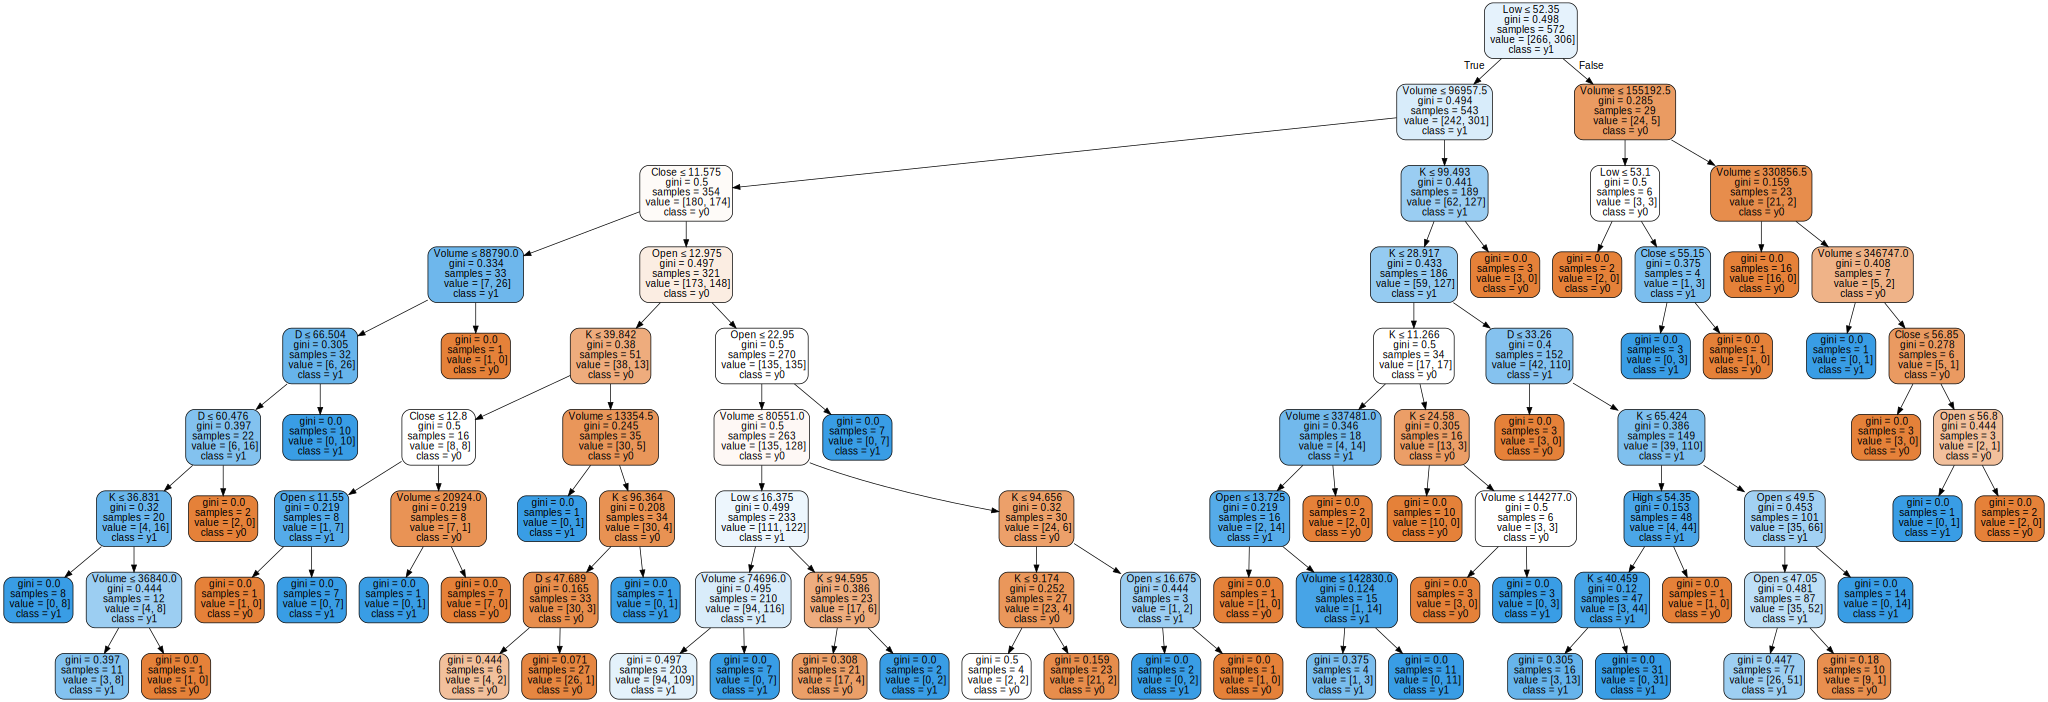

In [52]:
dot_data = export_graphviz(model, out_file = None,
                           feature_names = train_x.columns,
                           filled = True, rounded = True,
                           class_names = True,
                           special_characters = True)
graph = graphviz.Source(dot_data)
graph

In [53]:
# 混淆矩陣
m = confusion_matrix(test_y, prediction)
print(m)
# 準確率
model.score(test_x, test_y)

[[52 10]
 [52 24]]


0.5507246376811594

In [54]:
# 計算 ROC 曲線
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, prediction)

# 計算 AUC 面積
auc(false_positive_rate, true_positive_rate)

0.5772495755517828

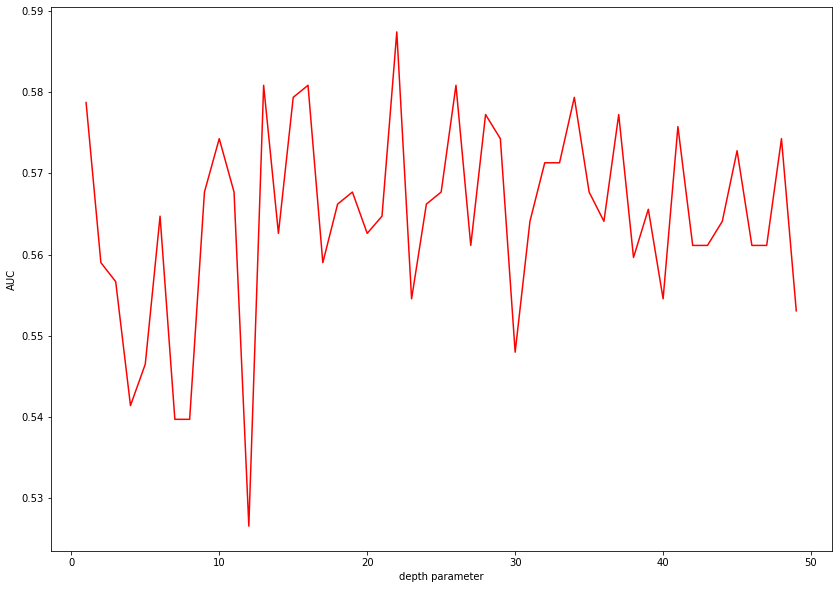

In [57]:
# 測試一批深度參數，一般而言深度不太會超過 3x，我們這邊示範 1 到 50 好了
depth_parameters = np.arange(1, 50)
# 準備兩個容器，一個裝所有參數下的訓練階段 AUC；另一個裝所有參數下的測試階段 AUC
train_auc= []
test_auc = []
# 根據每一個參數跑迴圈
for test_depth in depth_parameters:
    # 根據該深度參數，創立一個決策樹模型，取名 temp_model
    temp_model = DecisionTreeClassifier(max_depth = test_depth)
    # 讓 temp_model 根據 train 學習樣本進行學習
    temp_model.fit(train_x, train_y)
    # 讓學習後的 temp_model 分別根據 train 學習樣本以及 test 測試樣本進行測驗
    train_predictions = temp_model.predict(train_x)
    test_predictions = temp_model.predict(test_x)
    # 計算學習樣本的 AUC，並且紀錄起來
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_y, train_predictions)
    auc_area = auc(false_positive_rate, true_positive_rate)
    train_auc.append(auc_area)
    # 計算測試樣本的 AUC，並且紀錄起來
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, test_predictions)
    auc_area = auc(false_positive_rate, true_positive_rate)
    test_auc.append(auc_area)

# 繪圖視覺化
plt.figure(figsize = (14,10))
# plt.plot(depth_parameters, train_auc, 'b', label = 'Train AUC')
plt.plot(depth_parameters, test_auc, 'r', label = 'Test AUC')
plt.ylabel('AUC')
plt.xlabel('depth parameter')
plt.show()

## 單支股票，單個策略

## bbands + ema

In [28]:
data = '2303'
# 讀取資料
ticker = read_ticker_v2(data + '.csv')

# # 標出交易策略多空點
# ticker = bbands_ema_rule(ticker, bb_period=20, bb_stdnum=2, ma_period=5)

# # 數據回測
# ticker = back_track_v5(ticker, 500_000, stop_loss_percent=0.95) # 起始資金為五十萬

# 繪圖
dff = ticker.loc['2015-10':'2016-10', ]
plot_muti(dff, _title='', volume=True, buy_sell_point=True, 
    RSI=False, rsi_midline=False, rsi_bound=True, rsi_upper_bound=60, rsi_lower_bound=40, 
    KD=False, kd_bound=True, kd_upper_bound=60, kd_lower_bound=40, 
    MACD=False, BBands=True)

# # 計算交易資訊
# result = get_trade_info_v2(ticker)

# print(result)

# # 計算投資報酬率
# profit = get_result(result)
# print(profit)

# result.to_csv(data + '_result.csv')

KeyError: 'bbands_middle'

## kd + rsi

In [ ]:
data = '0050_2018'
# 讀取資料
ticker = read_ticker_v2(data + '.csv')

# 標出交易策略多空點
ticker = kd_rsi_rule(ticker, rsi_buy_point=35, rsi_sell_point=65)

# 數據回測
ticker = back_track_v5(ticker, 500_000, stop_loss_percent=0.95) # 起始資金為五十萬

# 繪圖
dff = ticker.loc['2020-06':'2021-10', ]
plot_muti(dff, _title='', volume=True, buy_sell_point=True, 
    RSI=True, rsi_midline=False, rsi_bound=True, rsi_upper_bound=65, rsi_lower_bound=35, 
    KD=True, kd_bound=False, kd_upper_bound=85, kd_lower_bound=15, 
    MACD=False, BBands=False)

# 計算交易資訊
result = get_trade_info_v2(ticker)

print(result)

# 計算投資報酬率
profit = get_result(result)
print(profit)

result.to_csv(data + '_result.csv')

## MA + MACD

In [ ]:
data = '0050_2018'
# 讀取資料
ticker = read_ticker_v2(data + '.csv')

# 標出交易策略多空點
ticker = macd_ma_rule(ticker, buy_point_name='buy_point', ma_period=5)

# 數據回測
ticker = back_track_v5(ticker, 500_000, stop_loss_percent=0.95) # 起始資金為五十萬

# 繪圖
dff = ticker.loc['2020-06':'2021-10', ]
plot_muti(dff, _title='', volume=True, buy_sell_point=True, 
    RSI=False, rsi_midline=True, rsi_bound=True, rsi_upper_bound=85, rsi_lower_bound=15, 
    KD=False, kd_bound=True, kd_upper_bound=85, kd_lower_bound=15, 
    MACD=True, BBands=False)

# 計算交易資訊
result = get_trade_info_v2(ticker)

print(result)

# 計算投資報酬率
profit = get_result(result)
print(profit)

result.to_csv(data + '_result.csv')

## 多支股票結果比較

## bband + ema

In [ ]:
# 取得資料名稱串列
ticker_list = get_ticker_list()

# 回傳資料
res = []
# 總報酬
profit_sum = 0

for data in ticker_list:

    print(data)

    # 讀取資料
    ticker = read_ticker_v2(data)

    # 標出交易策略多空點
    ticker = bbands_ema_rule(ticker, bb_period=20, bb_stdnum=2, ma_period=5)

    # 數據回測
    ticker = back_track_v5(ticker, 500_000, stop_loss_percent=0.96)

    # 計算交易資訊
    result = get_trade_info_v2(ticker)

    # 計算投資報酬率
    profit = get_result(result)

    # 將該支股票之報酬率加總
    profit_sum += profit[len(profit) - 1]

    # 將當前資料加入新的一列
    res += [profit]
    
# 將陣列資料轉乘 dataframe
res = pd.DataFrame(res)

# 加入各列資料名稱 
res.set_axis(ticker_list, axis='rows', inplace=True)

# 加入各行數據名稱
res.set_axis(['Trades', 'Win', 'Loss', 'Win_Rate', 'Profit'], axis='columns', inplace=True)

# 印出總結果
print(res)

# 印出平均報酬率
print('平均報酬率 :', profit_sum / len(ticker_list))

## kd + rsi

In [ ]:
# 取得資料名稱串列
ticker_list = get_ticker_list()

# 回傳資料
res = []
# 總報酬
profit_sum = 0

for data in ticker_list:

    print(data)

    # 讀取資料
    ticker = read_ticker_v2(data)

    # 標出交易策略多空點
    ticker = kd_rsi_rule(ticker, rsi_buy_point=35, rsi_sell_point=65)

    # 數據回測
    ticker = back_track_v5(ticker, 500_000, stop_loss_percent=0.95)

    # 計算交易資訊
    result = get_trade_info_v2(ticker)

    # 計算投資報酬率
    profit = get_result(result)

    # 將該支股票之報酬率加總
    profit_sum += profit[len(profit) - 1]

    # 將當前資料加入新的一列
    res += [profit]
    
# 將陣列資料轉乘 dataframe
res = pd.DataFrame(res)

# 加入各列資料名稱 
res.set_axis(ticker_list, axis='rows', inplace=True)

# 加入各行數據名稱
res.set_axis(['Trades', 'Win', 'Loss', 'Win_Rate', 'Profit'], axis='columns', inplace=True)

# 印出總結果
print(res)

# 印出平均報酬率
print('平均報酬率 :', profit_sum / len(ticker_list))

## ma + macd

In [ ]:
# 取得資料名稱串列
ticker_list = get_ticker_list()

# 回傳資料
res = []
# 總報酬
profit_sum = 0

for data in ticker_list:

    print(data)

    # 讀取資料
    ticker = read_ticker_v2(data)

    # 標出交易策略多空點
    ticker = macd_ma_rule(ticker, buy_point_name='buy_point', ma_period=4)

    # 數據回測
    ticker = back_track_v5(ticker, 500_000, stop_loss_percent=0.95)

    # 計算交易資訊
    result = get_trade_info_v2(ticker)

    # 計算投資報酬率
    profit = get_result(result)

    # 將該支股票之報酬率加總
    profit_sum += profit[len(profit) - 1]

    # 將當前資料加入新的一列
    res += [profit]
    
# 將陣列資料轉乘 dataframe
res = pd.DataFrame(res)

# 加入各列資料名稱 
res.set_axis(ticker_list, axis='rows', inplace=True)

# 加入各行數據名稱
res.set_axis(['Trades', 'Win', 'Loss', 'Win_Rate', 'Profit'], axis='columns', inplace=True)

# 印出總結果
print(res)

# 印出平均報酬率
print('平均報酬率 :', profit_sum / len(ticker_list))